<a href="https://colab.research.google.com/github/TimWue/facialExpressionRecognition/blob/main/EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-utils
!pip install opencv-python
!pip install tensorflow-datasets
!pip install --upgrade tensorflow
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install tensorflowjs
!pip install alibi
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for opencv-utils: filename=opencv_utils-0.0.2-py3-none-any.whl size=6116 sha256=6484df2455394e30b0fb82af6c721d628a61ae315ff9ab2fe57942f2f139b7ec
  Stored in directory: /root/.cache/pip/wheels/e7/f6/fd/d5de05fdbca1e21827425dfb3273cbb546bb0b5c1a510df1e2
Successfully built opencv-utils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8

In [2]:
from os import listdir
import os
from PIL import Image as PImage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD
import cv2
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten
import tensorflow_datasets as tfds
import glob
import zipfile
import tensorflowjs as tfjs
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from typing import List
import visualkeras


%matplotlib inline

In [3]:
# Download data from https://www.kaggle.com/datasets/msambare/fer2013
# Upload downloaded zip file manually BEFORE executing the following
zip_name = 'fer2013.zip'

files = glob.glob(zip_name)
for file in files:
    print('Unzipping:',file)
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('./')


Unzipping: fer2013.zip


In [4]:
!nvidia-smi -L
tf.config.list_physical_devices('GPU')

GPU 0: Tesla T4 (UUID: GPU-49cf0e88-1c17-5789-511d-850d5c30450c)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
def showHistory(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')


In [6]:
def showDataOverview(train_labels, test_labels , class_names):
  assert(len(set(train_labels)) == len(set(train_labels)) & len(set(train_labels)) == len(class_names))

  bar_width = 0.8
  colors = plt.cm.BuPu(np.linspace(0.5, 1, 2))

  fig, ax = plt.subplots()
  plt.gcf().set_size_inches(8, 8)
  for index, class_name in enumerate(class_names):
    count_train_class = np.count_nonzero(train_labels == index)
    count_test_class = np.count_nonzero(test_labels == index)

    train_plot = plt.bar(index, count_train_class, bar_width, bottom=0, color = colors[0])
    test_plot = plt.bar(index, count_test_class, bar_width, bottom=count_train_class, color = colors[1])

  plt.title('Overview FER2013')
  ax.set_xticks(np.arange(len(class_names)))
  ax.set_xticklabels(class_names)
  ax.legend([train_plot,test_plot], ["Training", "Test"])
  plt.show()



In [7]:
def extractFaces(image_path, out_file, out_size):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
            gray,
            minNeighbors=3,
            flags=0,
            minSize=(0, 0)
    ) 

    for (x, y, w, h) in faces:
      # We want (almost) squared images
      try :
        if (w > h):
          diff = w - h
          newImg = image[x:x+w, y - round(diff / 2): y - round(diff / 2) + w]
        else:
          diff = h - w
          newImg = image[x - round(diff / 2): x- round(diff / 2) + h, y : y  + h]
        
        # resize image
        output = cv2.resize(newImg, out_size)
        cv2.imwrite(out_file, output)
      except:
        print("Error in face detection")



In [8]:
# Extract faces of images
def preprocess():
    data_base_path = "./"
    dataset_path = "fer2013/"
    processed_base_path = "new/"
    out_size = (48,48)

    base_path = data_base_path + dataset_path
    processed_path = data_base_path + processed_base_path

    first_level= listdir(base_path)

    if not os.path.exists(processed_path):
                os.makedirs(processed_path)

    for folder in first_level:
        second_level = listdir( base_path + folder)
        for emotionFolder in second_level:
            saveDirection = processed_path + folder + "/" + emotionFolder
            workingDirection = base_path + folder + "/" + emotionFolder
            images = listdir(workingDirection)
            print(workingDirection)
            if not os.path.exists(saveDirection):
                os.makedirs(saveDirection)
            for image in images:
                extractFaces(workingDirection + "/" + image, saveDirection + "/" + image, out_size)

In [11]:
# Preprocess the data if needed

PREPROCESS = False;

if (PREPROCESS):
  preprocess()
  zf = zipfile.ZipFile(zip_name, "w")
  for dirname, subdirs, files in os.walk(zip_name):
      zf.write(dirname)
      for filename in files:
          zf.write(os.path.join(dirname, filename))
  zf.close()

In [9]:
# Show example image
def showOneImageOfDataset(dataset, toUint8, image_size_x = 48, image_size_y = 48, is_one_hot = False):
  for images, labels in dataset.take(1):
      first_image_of_batch = images.numpy()[0]
      first_label_of_batch = labels.numpy()[0]
      assert(image_size_x * image_size_y * 3 == first_image_of_batch.size)

      min_val = first_image_of_batch.min()
      max_val = first_image_of_batch.max()

      img = first_image_of_batch.reshape(image_size_x,image_size_y,3)

      if (toUint8):
        img = img.astype(np.uint8)

      title = ""

      if (is_one_hot):
        title = class_names[np.argmax(first_label_of_batch, axis=0)]
      else:
        title = class_names[first_label_of_batch]

      fig = plt.figure(frameon=False)
      plt.imshow(img,vmin=min_val,vmax=max_val, cmap="gray")
      plt.title(title)
      plt.colorbar()


In [10]:
def print_predictions(class_names, predictions):
  num_classes = len(class_names)
  for i in range(num_classes):
    print(f'{class_names[i]}: {"{:.2f}".format(100 * predictions[0][i])}%')

In [11]:
# Load data from directory
datasetBasePath = "./" 
image_size_x = 48
image_size_y = 48
image_size = (image_size_x, image_size_y)
batch_size = 32
seed=1337

dataset_train = image_dataset_from_directory(
    datasetBasePath +"/train/", 
    image_size=image_size,
    seed=seed,
    batch_size=batch_size,
    shuffle=True
)

dataset_test = image_dataset_from_directory(
    datasetBasePath +"/test/", 
    image_size=image_size, 
    seed=seed,
    batch_size=batch_size,
    shuffle=True)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [12]:
class_names = dataset_train.class_names
num_classes = len(class_names)
input_shape=(image_size_x, image_size_y, 3)

print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


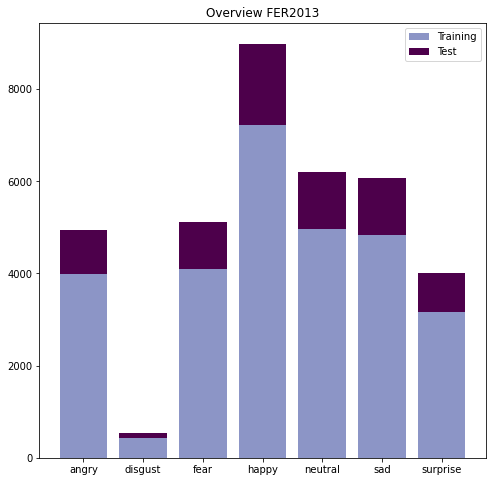

In [13]:
# Show overview
train_labels = y = np.concatenate([y for x, y in dataset_train], axis=0)
test_labels = y = np.concatenate([y for x, y in dataset_test], axis=0)
showDataOverview(train_labels,test_labels, class_names)

(array([ 273.,  252.,   78.,   99.,  279., 1047., 1989., 1779.,  336.,
         780.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ], dtype=float32),
 <BarContainer object of 10 artists>)

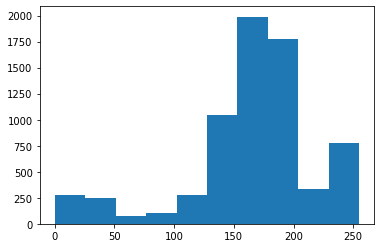

In [14]:
# Show some insights into data
all_data = iter(dataset_train.take(1)).next()[0][0].numpy().reshape(-1)
plt.hist(all_data)

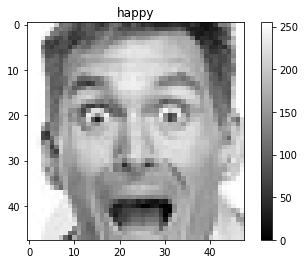

In [35]:
showOneImageOfDataset(dataset_train, True)

Diese Plots zeigen Overfitting, deshalb muss dem entgegengewirkt werden. Hierfür werden zwei Änderungen eingeführt:
- Data-Augmentation: Leichtes Verändern der Input-Bilder um "genereller" zu lernen
- Dropout 

In [36]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=input_shape),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [22]:
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

dropout = 0.5

model = tf.keras.Sequential()

model.add(InputLayer(input_shape=input_shape, name='input'))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [23]:
epochs=2
history = model.fit(
  dataset_train,
  validation_data=dataset_test,
  epochs=epochs,
  batch_size=50, 
  shuffle=True,
)

Epoch 1/2
898/898 [==============================] - 16s 12ms/step - loss: 2.1053 - accuracy: 0.2298 - val_loss: 1.7044 - val_accuracy: 0.3121
Epoch 2/2
898/898 [==============================] - 14s 15ms/step - loss: 1.7111 - accuracy: 0.3184 - val_loss: 1.6040 - val_accuracy: 0.3802


In [24]:
# Load (manually upload model file before)
#model = keras.models.load_model('./model_22_08')


# Save (h5 format works best. for tensorflow.js we have to use a command line transformer)
# model.save('./model_12_03_23')  # save in new format
model.save('./model_12_03__5.h5') # save in old format which can be converted to tensorflowjs format or imported by dl4j

#model.save('./model_12_03__3',save_format='h5') # save in old format which can be converted to tensorflowjs format or imported by dl4j
#tfjs.converters.save_keras_model(model, "./") # save directly in tensorflowjs format

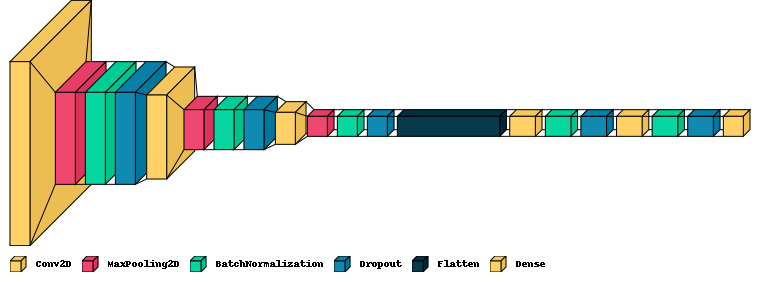

In [43]:
visualkeras.layered_view(model, legend=True, to_file='model_custom.png') # write to disk

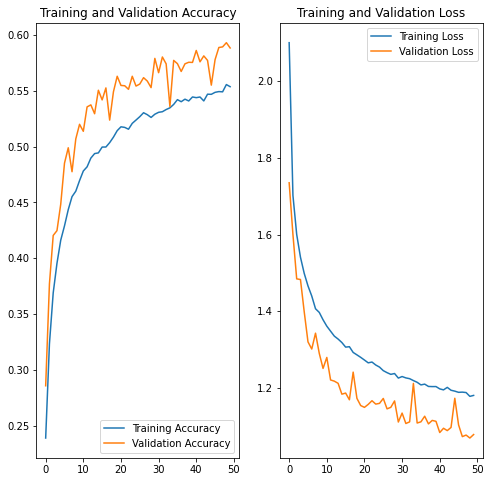

In [44]:
showHistory(history,epochs)

1/1 [==============================] - 0s 25ms/step


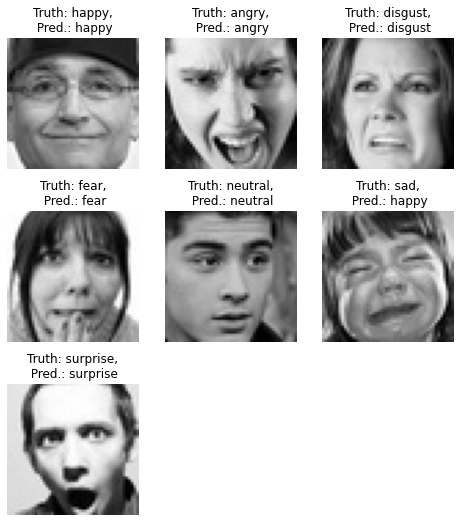

In [45]:
# Show some predictions (Depending on the dataset used, "files" must be edited because some file may have not survived preprocessing)

files = [
    "happy/PrivateTest_40251698",
    "angry/PrivateTest_2775163",
    "disgust/PrivateTest_4783181",
    "fear/PrivateTest_11251019",
    "neutral/PrivateTest_2134320",
    "sad/PrivateTest_16163666",
    "surprise/PrivateTest_3036992"
    ]

plt.gcf().set_size_inches(8, 9)

for index, currentFile in enumerate(files):    # add a new subplot iteratively
    img_path = "./test/" + currentFile + ".jpg"
    img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=image_size
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    max_index = predictions.argmax()

    ax = plt.subplot(3, 3, index + 1)
    emotion = currentFile.split('/')[0]
    plt.title("Truth: " + emotion + ",\n Pred.: " + class_names[max_index])
    plt.axis('off')
    ax.set_xlabel("")
    plt.imshow(img);


In [46]:
# Take whole test dataset to evaluate predictions
sample_size = 7178
deterministic_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./test/", 
    seed=seed,
    image_size=image_size,
    batch_size=sample_size,
    shuffle=True
).map(lambda image, label: (image, label))

val_image_batch, val_label_batch = next(iter(deterministic_val_ds))
y_pred = model.predict(val_image_batch).argmax(axis=1)
y_true = val_label_batch.numpy()


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Found 7178 files belonging to 7 classes.
225/225 [==============================] - 1s 3ms/step


Show some wrong predictions

In [47]:
predictions_wrong = y_pred != y_true
elements_wrong_predicted = [i for i, prediction_wrong in enumerate(predictions_wrong) if prediction_wrong]

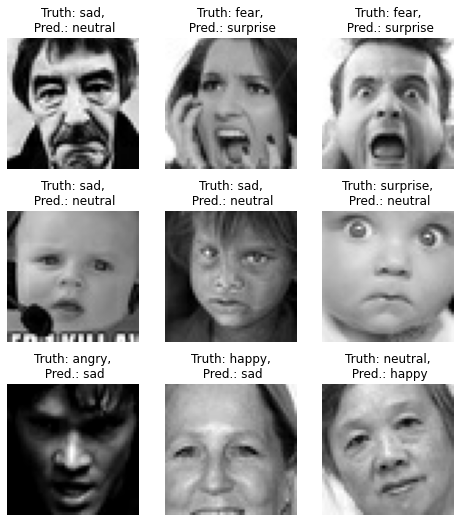

In [48]:
random_wrong_elements = random.choices(elements_wrong_predicted, k=9)
plt.gcf().set_size_inches(8, 9)
for index, element in enumerate(random_wrong_elements):   
    truth = class_names[y_true[element]]
    prediction = class_names[y_pred[element]]
    ax = plt.subplot(3, 3, index + 1)
    plt.title("Truth: " + truth + ",\n Pred.: " + prediction)
    plt.axis('off')
    ax.set_xlabel("")
    img = tf.keras.utils.array_to_img(val_image_batch[element,:,:,:])
    plt.imshow(img)

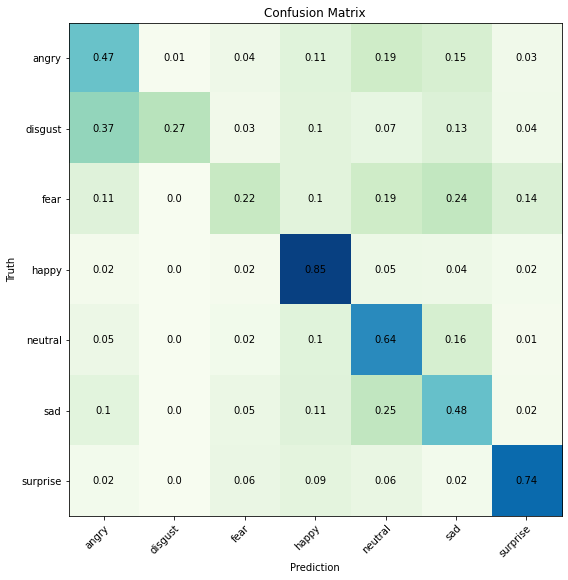

In [49]:
# SHow confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize="true")

fig, ax = plt.subplots()
plt.gcf().set_size_inches(8, 9)

im = ax.imshow(cm,cmap="GnBu")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")


# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, round(cm[i, j],2),
                       ha="center", va="center", color="k")

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

###Normalisierung 
Wenn "normalize=true", dann wird bzgl der Truth values normalisiert. Heißt: die summe der Zahlen einer Reihe ergibt 1 (100%). Daraus kann man aussagen treffen wie: 15% aller "neutral" Bilder wurden als "angry predicted



#The following is all MobileNetV2 stuff (not working)



In [ ]:
def preprocess(images, labels):
  return tf.keras.applications.mobilenet_v2.preprocess_input(tf.image.resize(images,[224,224])), tf.one_hot(labels, num_classes)


In [ ]:
x_train =dataset_train.map(preprocess)
x_test = dataset_test.map(preprocess)

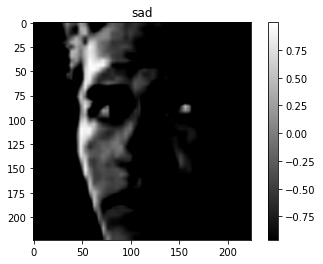

In [ ]:
showOneImageOfDataset(x_train, False, 224,224, True)

In [ ]:
model = tf.keras.applications.MobileNetV2(
    input_shape=(image_size_x,image_size_y,3),
    alpha=1.0,
    include_top = False,
    weights=None
)
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(48, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu' ),
  layers.Dense(num_classes,activation='softmax')
])

#model.add(layers.Flatten())
#model.add(layers.Dense(128, activation='relu' ))
#
#model.add(layers.Dense(num_classes,activation='softmax'))
#
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
#model.summary()
epochs=3
history = model.fit(
  x_train,
  validation_data=x_test,
  epochs=epochs
)


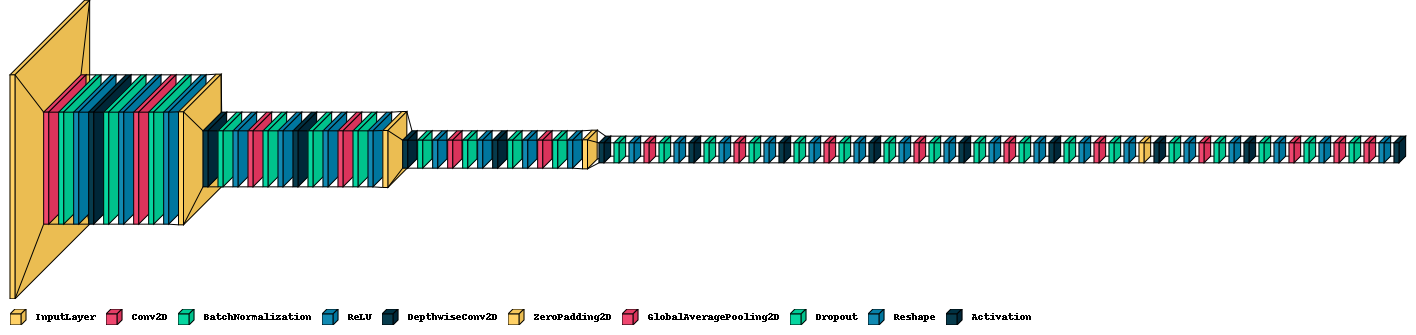

In [ ]:
model = tf.keras.applications.MobileNet()
visualkeras.layered_view(model, legend=True, to_file='mobilenet.png', scale_xy=1, scale_z=1, max_z=5) # write to disk



In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=True,
    weights='imagenet')

for layer in base_model.layers:
    layer.trainable = True  # trainable has to be false in order to freeze the layers

model = keras.Sequential([
  base_model,
  layers.Dense(128, activation='relu' ),
  layers.Dense(num_classes,activation='softmax')
])


model.compile(optimizer="adam",
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=20
history = model.fit(
  x_train,
  validation_data=x_test,
  epochs=epochs,
)


Epoch 1/20
898/898 [==============================] - 199s 217ms/step - loss: 1.6643 - accuracy: 0.3342 - val_loss: 2.1491 - val_accuracy: 0.2474
Epoch 2/20
898/898 [==============================] - 197s 220ms/step - loss: 1.4355 - accuracy: 0.4293 - val_loss: 1.7534 - val_accuracy: 0.3381
Epoch 3/20
898/898 [==============================] - 199s 222ms/step - loss: 1.3383 - accuracy: 0.4707 - val_loss: 1.8403 - val_accuracy: 0.3879
Epoch 4/20
898/898 [==============================] - 198s 221ms/step - loss: 1.2496 - accuracy: 0.5213 - val_loss: 1.8947 - val_accuracy: 0.3260
Epoch 5/20
898/898 [==============================] - 198s 220ms/step - loss: 1.1700 - accuracy: 0.5468 - val_loss: 1.7256 - val_accuracy: 0.4189
Epoch 6/20
898/898 [==============================] - 199s 221ms/step - loss: 1.1056 - accuracy: 0.5777 - val_loss: 1.6098 - val_accuracy: 0.4430
Epoch 7/20
898/898 [==============================] - 198s 220ms/step - loss: 1.0493 - accuracy: 0.6035 - val_loss: 1.5377 -

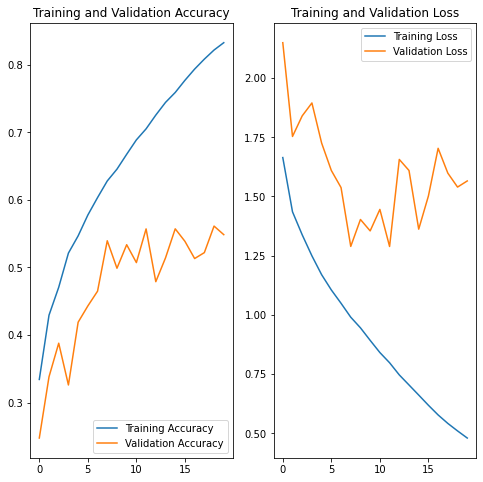

In [ ]:
showHistory(history,epochs)